In [ ]:
#|hide
#| eval: false
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
#|export
from __future__ import annotations
from fastai.basics import *
from fastai.vision.all import *

In [ ]:
#|default_exp vision.gan
#|default_cls_lvl 3

In [ ]:
#|hide
from nbdev.showdoc import *

# GAN

> Basic support for [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)

GAN stands for [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf) and were invented by Ian Goodfellow. The concept is that we train two models at the same time: a generator and a critic. The generator will try to make new images similar to the ones in a dataset, and the critic will try to classify real images from the ones the generator does. The generator returns images, the critic a single number (usually a probability, 0. for fake images and 1. for real ones).

We train them against each other in the sense that at each step (more or less), we:

1. Freeze the generator and train the critic for one step by:
  - getting one batch of true images (let's call that `real`)
  - generating one batch of fake images (let's call that `fake`)
  - have the critic evaluate each batch and compute a loss function from that; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the critic with the gradients of this loss
  
  
2. Freeze the critic and train the generator for one step by:
  - generating one batch of fake images
  - evaluate the critic on it
  - return a loss that rewards positively the critic thinking those are real images
  - update the weights of the generator with the gradients of this loss

:::{.callout-note}

The fastai library provides support for training GANs through the GANTrainer, but doesn't include more than basic models.

:::

## Wrapping the modules

In [ ]:
#|export
class GANModule(Module):
    "Wrapper around a `generator` and a `critic` to create a GAN."
    def __init__(self,
        generator:nn.Module=None, # The generator PyTorch module
        critic:nn.Module=None, # The discriminator PyTorch module
        gen_mode:None|bool=False # Whether the GAN should be set to generator mode
    ):
        if generator is not None: self.generator=generator
        if critic    is not None: self.critic   =critic
        store_attr('gen_mode')

    def forward(self, *args):
        return self.generator(*args) if self.gen_mode else self.critic(*args)

    def switch(self,
        gen_mode:None|bool=None # Whether the GAN should be set to generator mode
    ):
        "Put the module in generator mode if `gen_mode` is `True`, in critic mode otherwise."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode

This is just a shell to contain the two models. When called, it will either delegate the input to the `generator` or the `critic` depending of the value of `gen_mode`.

In [ ]:
show_doc(GANModule.switch)

---

[source](https://github.com/fastai/fastai/blob/master/fastai/vision/gan.py#L31){target="_blank" style="float:right; font-size:smaller"}

### GANModule.switch

>      GANModule.switch (gen_mode:None|bool=None)

*Put the module in generator mode if `gen_mode` is `True`, in critic mode otherwise.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| gen_mode | None \| bool | None | Whether the GAN should be set to generator mode |

By default (leaving `gen_mode` to `None`), this will put the module in the other mode (critic mode if it was in generator mode and vice versa).

In [ ]:
#|export
@delegates(ConvLayer.__init__)
def basic_critic(
    in_size:int, # Input size for the critic (same as the output size of the generator)
    n_channels:int, # Number of channels of the input for the critic
    n_features:int=64, # Number of features used in the critic
    n_extra_layers:int=0, # Number of extra hidden layers in the critic
    norm_type:NormType=NormType.Batch, # Type of normalization to use in the critic
    **kwargs
) -> nn.Sequential:
    "A basic critic for images `n_channels` x `in_size` x `in_size`."
    layers = [ConvLayer(n_channels, n_features, 4, 2, 1, norm_type=None, **kwargs)]
    cur_size, cur_ftrs = in_size//2, n_features
    layers += [ConvLayer(cur_ftrs, cur_ftrs, 3, 1, norm_type=norm_type, **kwargs) for _ in range(n_extra_layers)]
    while cur_size > 4:
        layers.append(ConvLayer(cur_ftrs, cur_ftrs*2, 4, 2, 1, norm_type=norm_type, **kwargs))
        cur_ftrs *= 2 ; cur_size //= 2
    init = kwargs.get('init', nn.init.kaiming_normal_)
    layers += [init_default(nn.Conv2d(cur_ftrs, 1, 4, padding=0), init), Flatten()]
    return nn.Sequential(*layers)

In [ ]:
#|export
class AddChannels(Module):
    "Add `n_dim` channels at the end of the input."
    def __init__(self, n_dim): self.n_dim=n_dim
    def forward(self, x): return x.view(*(list(x.shape)+[1]*self.n_dim))

In [ ]:
#|export
@delegates(ConvLayer.__init__)
def basic_generator(
    out_size:int, # Output size for the generator (same as the input size for the critic)
    n_channels:int, # Number of channels of the output of the generator
    in_sz:int=100, # Size of the input noise vector for the generator
    n_features:int=64, # Number of features used in the generator
    n_extra_layers:int=0, # Number of extra hidden layers in the generator
    **kwargs
) -> nn.Sequential:
    "A basic generator from `in_sz` to images `n_channels` x `out_size` x `out_size`."
    cur_size, cur_ftrs = 4, n_features//2
    while cur_size < out_size:  cur_size *= 2; cur_ftrs *= 2
    layers = [AddChannels(2), ConvLayer(in_sz, cur_ftrs, 4, 1, transpose=True, **kwargs)]
    cur_size = 4
    while cur_size < out_size // 2:
        layers.append(ConvLayer(cur_ftrs, cur_ftrs//2, 4, 2, 1, transpose=True, **kwargs))
        cur_ftrs //= 2; cur_size *= 2
    layers += [ConvLayer(cur_ftrs, cur_ftrs, 3, 1, 1, transpose=True, **kwargs) for _ in range(n_extra_layers)]
    layers += [nn.ConvTranspose2d(cur_ftrs, n_channels, 4, 2, 1, bias=False), nn.Tanh()]
    return nn.Sequential(*layers)

In [ ]:
critic = basic_critic(64, 3)
generator = basic_generator(64, 3)
tst = GANModule(critic=critic, generator=generator)
real = torch.randn(2, 3, 64, 64)
real_p = tst(real)
test_eq(real_p.shape, [2,1])

tst.switch() #tst is now in generator mode
noise = torch.randn(2, 100)
fake = tst(noise)
test_eq(fake.shape, real.shape)

tst.switch() #tst is back in critic mode
fake_p = tst(fake)
test_eq(fake_p.shape, [2,1])

In [ ]:
#|export
_conv_args = dict(act_cls = partial(nn.LeakyReLU, negative_slope=0.2), norm_type=NormType.Spectral)

def _conv(ni, nf, ks=3, stride=1, self_attention=False, **kwargs):
    if self_attention: kwargs['xtra'] = SelfAttention(nf)
    return ConvLayer(ni, nf, ks=ks, stride=stride, **_conv_args, **kwargs)

In [ ]:
#|export
@delegates(ConvLayer)
def DenseResBlock(
    nf:int, # Number of features
    norm_type:NormType=NormType.Batch, # Normalization type
    **kwargs
) -> SequentialEx:
    "Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`."
    return SequentialEx(ConvLayer(nf, nf, norm_type=norm_type, **kwargs),
                        ConvLayer(nf, nf, norm_type=norm_type, **kwargs),
                        MergeLayer(dense=True))

In [ ]:
#|export
def gan_critic(
    n_channels:int=3, # Number of channels of the input for the critic
    nf:int=128, # Number of features for the critic
    n_blocks:int=3, # Number of ResNet blocks within the critic
    p:float=0.15 # Amount of dropout in the critic
) -> nn.Sequential:
    "Critic to train a `GAN`."
    layers = [
        _conv(n_channels, nf, ks=4, stride=2),
        nn.Dropout2d(p/2),
        DenseResBlock(nf, **_conv_args)]
    nf *= 2 # after dense block
    for i in range(n_blocks):
        layers += [
            nn.Dropout2d(p),
            _conv(nf, nf*2, ks=4, stride=2, self_attention=(i==0))]
        nf *= 2
    layers += [
        ConvLayer(nf, 1, ks=4, bias=False, padding=0, norm_type=NormType.Spectral, act_cls=None),
        Flatten()]
    return nn.Sequential(*layers)

In [ ]:
#|export
class GANLoss(GANModule):
    "Wrapper around `crit_loss_func` and `gen_loss_func`"
    def __init__(self,
        gen_loss_func:callable, # Generator loss function
        crit_loss_func:callable, # Critic loss function
        gan_model:GANModule # The GAN model
    ):
        super().__init__()
        store_attr('gen_loss_func,crit_loss_func,gan_model')

    def generator(self,
        output, # Generator outputs
        target # Real images
    ):
        "Evaluate the `output` with the critic then uses `self.gen_loss_func` to evaluate how well the critic was fooled by `output`"
        fake_pred = self.gan_model.critic(output)
        self.gen_loss = self.gen_loss_func(fake_pred, output, target)
        return self.gen_loss

    def critic(self,
        real_pred, # Critic predictions for real images
        input # Input noise vector to pass into generator
    ):
        "Create some `fake_pred` with the generator from `input` and compare them to `real_pred` in `self.crit_loss_func`."
        fake = self.gan_model.generator(input).requires_grad_(False)
        fake_pred = self.gan_model.critic(fake)
        self.crit_loss = self.crit_loss_func(real_pred, fake_pred)
        return self.crit_loss

In [ ]:
show_doc(GANLoss.generator)

---

[source](https://github.com/fastai/fastai/blob/master/fastai/vision/gan.py#L139){target="_blank" style="float:right; font-size:smaller"}

### GANLoss.generator

>      GANLoss.generator (output, target)

*Evaluate the `output` with the critic then uses `self.gen_loss_func` to evaluate how well the critic was fooled by `output`*

|    | **Details** |
| -- | ----------- |
| output | Generator outputs |
| target | Real images |

In [ ]:
show_doc(GANLoss.critic)

---

[source](https://github.com/fastai/fastai/blob/master/fastai/vision/gan.py#L148){target="_blank" style="float:right; font-size:smaller"}

### GANLoss.critic

>      GANLoss.critic (real_pred, input)

*Create some `fake_pred` with the generator from `input` and compare them to `real_pred` in `self.crit_loss_func`.*

|    | **Details** |
| -- | ----------- |
| real_pred | Critic predictions for real images |
| input | Input noise vector to pass into generator |

If the `generator` method is called, this loss function expects the `output` of the generator and some `target` (a batch of real images). It will evaluate if the generator successfully fooled the critic using `gen_loss_func`. This loss function has the following signature
``` 
def gen_loss_func(fake_pred, output, target):
```
to be able to combine the output of the critic on `output` (which the first argument `fake_pred`) with `output` and `target` (if you want to mix the GAN loss with other losses for instance).

If the `critic` method is called, this loss function expects the `real_pred` given by the critic and some `input` (the noise fed to the generator). It will evaluate the critic using `crit_loss_func`. This loss function has the following signature
``` 
def crit_loss_func(real_pred, fake_pred):
```
where `real_pred` is the output of the critic on a batch of real images and `fake_pred` is generated from the noise using the generator.

In [ ]:
#|export
class AdaptiveLoss(Module):
    "Expand the `target` to match the `output` size before applying `crit`."
    def __init__(self, crit:callable): self.crit = crit
    def forward(self, output:Tensor, target:Tensor):
        return self.crit(output, target[:,None].expand_as(output).float())

In [ ]:
#|export
def accuracy_thresh_expand(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True):
    "Compute thresholded accuracy after expanding `y_true` to the size of `y_pred`."
    if sigmoid: y_pred = y_pred.sigmoid()
    return ((y_pred>thresh).byte()==y_true[:,None].expand_as(y_pred).byte()).float().mean()

## Callbacks for GAN training

In [ ]:
#|export
def set_freeze_model(
    m:nn.Module, # Model to freeze/unfreeze
    rg:bool # `Requires grad` argument. `True` for freeze
):
    for p in m.parameters(): p.requires_grad_(rg)

In [ ]:
#|export
class GANTrainer(Callback):
    "Callback to handle GAN Training."
    run_after = TrainEvalCallback
    def __init__(self,
        switch_eval:bool=False, # Whether the model should be set to eval mode when calculating loss
        clip:None|float=None, # How much to clip the weights
        beta:float=0.98, # Exponentially weighted smoothing of the losses `beta`
        gen_first:bool=False, # Whether we start with generator training
        show_img:bool=True, # Whether to show example generated images during training
    ):
        store_attr('switch_eval,clip,gen_first,show_img')
        self.gen_loss,self.crit_loss = AvgSmoothLoss(beta=beta),AvgSmoothLoss(beta=beta)

    def _set_trainable(self):
        "Appropriately set the generator and critic into a trainable or loss evaluation mode based on `self.gen_mode`."
        train_model = self.generator if     self.gen_mode else self.critic
        loss_model  = self.generator if not self.gen_mode else self.critic
        set_freeze_model(train_model, True)
        set_freeze_model(loss_model, False)
        if self.switch_eval:
            train_model.train()
            loss_model.eval()

    def before_fit(self):
        "Initialization."
        self.generator,self.critic = self.model.generator,self.model.critic
        self.gen_mode = self.gen_first
        self.switch(self.gen_mode)
        self.crit_losses,self.gen_losses = [],[]
        self.gen_loss.reset() ; self.crit_loss.reset()
        #self.recorder.no_val=True
        #self.recorder.add_metric_names(['gen_loss', 'disc_loss'])
        #self.imgs,self.titles = [],[]

    def before_validate(self):
        "Switch in generator mode for showing results."
        self.switch(gen_mode=True)

    def before_batch(self):
        "Clamp the weights with `self.clip` if it's not None, set the correct input/target."
        if self.training and self.clip is not None:
            for p in self.critic.parameters(): p.data.clamp_(-self.clip, self.clip)
        if not self.gen_mode:
            (self.learn.xb,self.learn.yb) = (self.yb,self.xb)

    def after_batch(self):
        "Record `last_loss` in the proper list."
        if not self.training: return
        if self.gen_mode:
            self.gen_loss.accumulate(self.learn)
            self.gen_losses.append(self.gen_loss.value)
            self.last_gen = self.learn.to_detach(self.pred)
        else:
            self.crit_loss.accumulate(self.learn)
            self.crit_losses.append(self.crit_loss.value)

    def before_epoch(self):
        "Put the critic or the generator back to eval if necessary."
        self.switch(self.gen_mode)

    #def after_epoch(self):
    #    "Show a sample image."
    #    if not hasattr(self, 'last_gen') or not self.show_img: return
    #    data = self.learn.data
    #    img = self.last_gen[0]
    #    norm = getattr(data,'norm',False)
    #    if norm and norm.keywords.get('do_y',False): img = data.denorm(img)
    #    img = data.train_ds.y.reconstruct(img)
    #    self.imgs.append(img)
    #    self.titles.append(f'Epoch {epoch}')
    #    pbar.show_imgs(self.imgs, self.titles)
    #    return add_metrics(last_metrics, [getattr(self.smoothenerG,'smooth',None),getattr(self.smoothenerC,'smooth',None)])

    def switch(self, gen_mode=None):
        "Switch the model and loss function, if `gen_mode` is provided, in the desired mode."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
        self._set_trainable()
        self.model.switch(gen_mode)
        self.loss_func.switch(gen_mode)

:::{.callout-warning}

The GANTrainer is useless on its own, you need to complete it with one of the following switchers

:::

In [ ]:
#|export
class FixedGANSwitcher(Callback):
    "Switcher to do `n_crit` iterations of the critic then `n_gen` iterations of the generator."
    run_after = GANTrainer
    def __init__(self,
        n_crit:int=1, # How many steps of critic training before switching to generator
        n_gen:int=1 # How many steps of generator training before switching to critic
    ):
        store_attr('n_crit,n_gen')

    def before_train(self): self.n_c,self.n_g = 0,0

    def after_batch(self):
        "Switch the model if necessary."
        if not self.training: return
        if self.learn.gan_trainer.gen_mode:
            self.n_g += 1
            n_iter,n_in,n_out = self.n_gen,self.n_c,self.n_g
        else:
            self.n_c += 1
            n_iter,n_in,n_out = self.n_crit,self.n_g,self.n_c
        target = n_iter if isinstance(n_iter, int) else n_iter(n_in)
        if target == n_out:
            self.learn.gan_trainer.switch()
            self.n_c,self.n_g = 0,0

In [ ]:
#|export
class AdaptiveGANSwitcher(Callback):
    "Switcher that goes back to generator/critic when the loss goes below `gen_thresh`/`crit_thresh`."
    run_after = GANTrainer
    def __init__(self,
        gen_thresh:None|float=None, # Loss threshold for generator
        critic_thresh:None|float=None # Loss threshold for critic
    ):
        store_attr('gen_thresh,critic_thresh')

    def after_batch(self):
        "Switch the model if necessary."
        if not self.training: return
        if self.gan_trainer.gen_mode:
            if self.gen_thresh is None or self.loss < self.gen_thresh: self.gan_trainer.switch()
        else:
            if self.critic_thresh is None or self.loss < self.critic_thresh: self.gan_trainer.switch()

In [ ]:
#|export
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    run_after = GANTrainer
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def before_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training:
            self.learn.opt.set_hyper('lr', self.learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', self.learn.opt.hypers[0]['lr']/self.mult_lr)

## GAN data

In [ ]:
#|export
class InvisibleTensor(TensorBase):
    "TensorBase but show method does nothing"
    def show(self, ctx=None, **kwargs): return ctx

In [ ]:
#|export
def generate_noise(
    fn, # Dummy argument so it works with `DataBlock`
    size=100 # Size of returned noise vector
) -> InvisibleTensor:
    "Generate noise vector."
    return cast(torch.randn(size), InvisibleTensor)

We use the `generate_noise` function to generate noise vectors to pass into the generator for image generation.

In [ ]:
#|export
@dispatch
def show_batch(x:InvisibleTensor, y:TensorImage, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = get_show_batch_func(object)(x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

In [ ]:
#|export
@dispatch
def show_results(x:InvisibleTensor, y:TensorImage, samples, outs, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = [b.show(ctx=c, **kwargs) for b,c,_ in zip(outs.itemgot(0),ctxs,range(max_n))]
    return ctxs

In [ ]:
bs = 128
size = 64

In [ ]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])))

In [ ]:
path = untar_data(URLs.LSUN_BEDROOMS)

In [ ]:
dls = dblock.dataloaders(path, path=path, bs=bs)

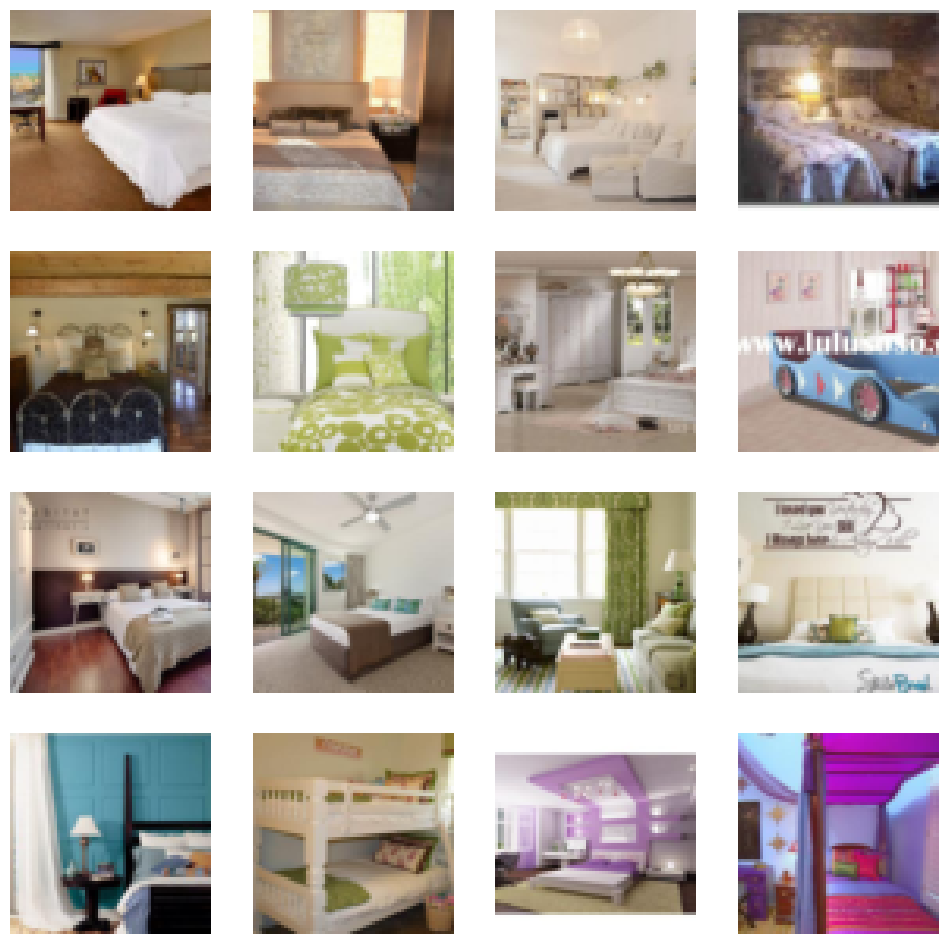

In [ ]:
dls.show_batch(max_n=16)

## GAN Learner

In [ ]:
#|export
def gan_loss_from_func(
    loss_gen:callable, # A loss function for the generator. Evaluates generator output images and target real images
    loss_crit:callable, # A loss function for the critic. Evaluates predictions of real and fake images.
    weights_gen:None|MutableSequence|tuple=None # Weights for the generator and critic loss function
):
    "Define loss functions for a GAN from `loss_gen` and `loss_crit`."
    def _loss_G(fake_pred, output, target, weights_gen=weights_gen):
        ones = fake_pred.new_ones(fake_pred.shape[0])
        weights_gen = ifnone(weights_gen, (1.,1.))
        return weights_gen[0] * loss_crit(fake_pred, ones) + weights_gen[1] * loss_gen(output, target)

    def _loss_C(real_pred, fake_pred):
        ones  = real_pred.new_ones (real_pred.shape[0])
        zeros = fake_pred.new_zeros(fake_pred.shape[0])
        return (loss_crit(real_pred, ones) + loss_crit(fake_pred, zeros)) / 2

    return _loss_G, _loss_C

In [ ]:
#|export
def _tk_mean(fake_pred, output, target): return fake_pred.mean()
def _tk_diff(real_pred, fake_pred): return real_pred.mean() - fake_pred.mean()

In [ ]:
#|export
@delegates()
class GANLearner(Learner):
    "A `Learner` suitable for GANs."
    def __init__(self,
        dls:DataLoaders, # DataLoaders object for GAN data
        generator:nn.Module, # Generator model
        critic:nn.Module, # Critic model
        gen_loss_func:callable, # Generator loss function
        crit_loss_func:callable, # Critic loss function
        switcher:Callback|None=None, # Callback for switching between generator and critic training, defaults to `FixedGANSwitcher`
        gen_first:bool=False, # Whether we start with generator training
        switch_eval:bool=True, # Whether the model should be set to eval mode when calculating loss
        show_img:bool=True, # Whether to show example generated images during training
        clip:None|float=None, # How much to clip the weights
        cbs:Callback|None|MutableSequence=None, # Additional callbacks
        metrics:None|MutableSequence|callable=None, # Metrics
        **kwargs
    ):
        gan = GANModule(generator, critic)
        loss_func = GANLoss(gen_loss_func, crit_loss_func, gan)
        if switcher is None: switcher = FixedGANSwitcher()
        trainer = GANTrainer(clip=clip, switch_eval=switch_eval, gen_first=gen_first, show_img=show_img)
        cbs = L(cbs) + L(trainer, switcher)
        metrics = L(metrics) + L(*LossMetrics('gen_loss,crit_loss'))
        super().__init__(dls, gan, loss_func=loss_func, cbs=cbs, metrics=metrics, **kwargs)

    @classmethod
    def from_learners(cls,
        gen_learn:Learner, # A `Learner` object that contains the generator
        crit_learn:Learner, # A `Learner` object that contains the critic
        switcher:Callback|None=None, # Callback for switching between generator and critic training, defaults to `FixedGANSwitcher`
        weights_gen:None|MutableSequence|tuple=None, # Weights for the generator and critic loss function
        **kwargs
    ):
        "Create a GAN from `learn_gen` and `learn_crit`."
        losses = gan_loss_from_func(gen_learn.loss_func, crit_learn.loss_func, weights_gen=weights_gen)
        return cls(gen_learn.dls, gen_learn.model, crit_learn.model, *losses, switcher=switcher, **kwargs)

    @classmethod
    def wgan(cls,
        dls:DataLoaders, # DataLoaders object for GAN data
        generator:nn.Module, # Generator model
        critic:nn.Module, # Critic model
        switcher:Callback|None=None, # Callback for switching between generator and critic training, defaults to `FixedGANSwitcher(n_crit=5, n_gen=1)`
        clip:None|float=0.01, # How much to clip the weights
        switch_eval:bool=False, # Whether the model should be set to eval mode when calculating loss
        **kwargs
    ):
        "Create a [WGAN](https://arxiv.org/abs/1701.07875) from `dls`, `generator` and `critic`."
        if switcher is None: switcher = FixedGANSwitcher(n_crit=5, n_gen=1)
        return cls(dls, generator, critic, _tk_mean, _tk_diff, switcher=switcher, clip=clip, switch_eval=switch_eval, **kwargs)

GANLearner.from_learners = delegates(to=GANLearner.__init__)(GANLearner.from_learners)
GANLearner.wgan = delegates(to=GANLearner.__init__)(GANLearner.wgan)

In [ ]:
show_doc(GANLearner.from_learners)

---

[source](https://github.com/fastai/fastai/blob/master/fastai/vision/gan.py#L397){target="_blank" style="float:right; font-size:smaller"}

### GANLearner.from_learners

>      GANLearner.from_learners (gen_learn:Learner, crit_learn:Learner,
>                                switcher:Callback|None=None,
>                                weights_gen:None|MutableSequence|tuple=None,
>                                gen_first:bool=False, switch_eval:bool=True,
>                                show_img:bool=True, clip:None|float=None,
>                                cbs:Callback|None|MutableSequence=None,
>                                metrics:None|MutableSequence|callable=None,
>                                loss_func:callable|None=None,
>                                opt_func:Optimizer|OptimWrapper=<function
>                                Adam>, lr:float|slice=0.001,
>                                splitter:callable=<function trainable_params>,
>                                path:str|Path|None=None,
>                                model_dir:str|Path='models',
>                                wd:float|int|None=None, wd_bn_bias:bool=False,
>                                train_bn:bool=True, moms:tuple=(0.95, 0.85,
>                                0.95), default_cbs:bool=True)

*Create a GAN from `learn_gen` and `learn_crit`.*

In [ ]:
show_doc(GANLearner.wgan)

---

[source](https://github.com/fastai/fastai/blob/master/fastai/vision/gan.py#L409){target="_blank" style="float:right; font-size:smaller"}

### GANLearner.wgan

>      GANLearner.wgan (dls:DataLoaders, generator:nn.Module, critic:nn.Module,
>                       switcher:Callback|None=None, clip:None|float=0.01,
>                       switch_eval:bool=False, gen_first:bool=False,
>                       show_img:bool=True,
>                       cbs:Callback|None|MutableSequence=None,
>                       metrics:None|MutableSequence|callable=None,
>                       loss_func:callable|None=None,
>                       opt_func:Optimizer|OptimWrapper=<function Adam>,
>                       lr:float|slice=0.001, splitter:callable=<function
>                       trainable_params>, path:str|Path|None=None,
>                       model_dir:str|Path='models', wd:float|int|None=None,
>                       wd_bn_bias:bool=False, train_bn:bool=True,
>                       moms:tuple=(0.95, 0.85, 0.95), default_cbs:bool=True)

*Create a [WGAN](https://arxiv.org/abs/1701.07875) from `dls`, `generator` and `critic`.*

In [ ]:
from fastai.callback.all import *

In [ ]:
generator = basic_generator(64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (64, n_channels=3, n_extra_layers=1, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))

In [ ]:
learn = GANLearner.wgan(dls, generator, critic, opt_func = RMSProp)

In [ ]:
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [ ]:
learn.fit(1, 2e-4, wd=0.)

/home/rd/git/repos/fastai/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/rd/git/repos/fastai/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/rd/git/repos/fastai/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,gen_loss,crit_loss,time
0,-0.813074,0.644724,-1.164965,01:13


/home/rd/git/.venv/lib/python3.12/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


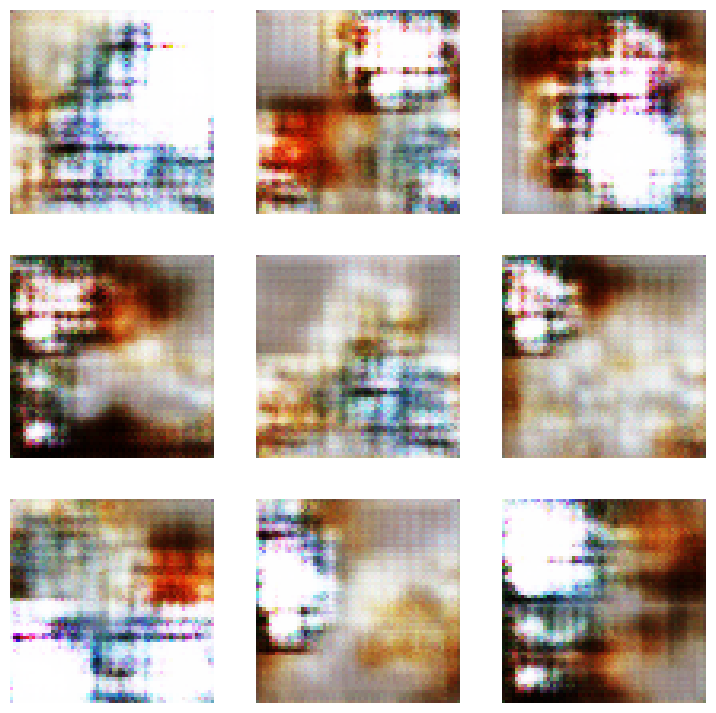

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

## Export -

In [ ]:
#|hide
from nbdev import nbdev_export
nbdev_export()